In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import string
import sys

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import superscreen as sc

sys.path.append("../code/squids")
import hypres

# figure_dir = None
figure_dir = "../latex/figures"

In [2]:
squid = hypres.small.make_squid()

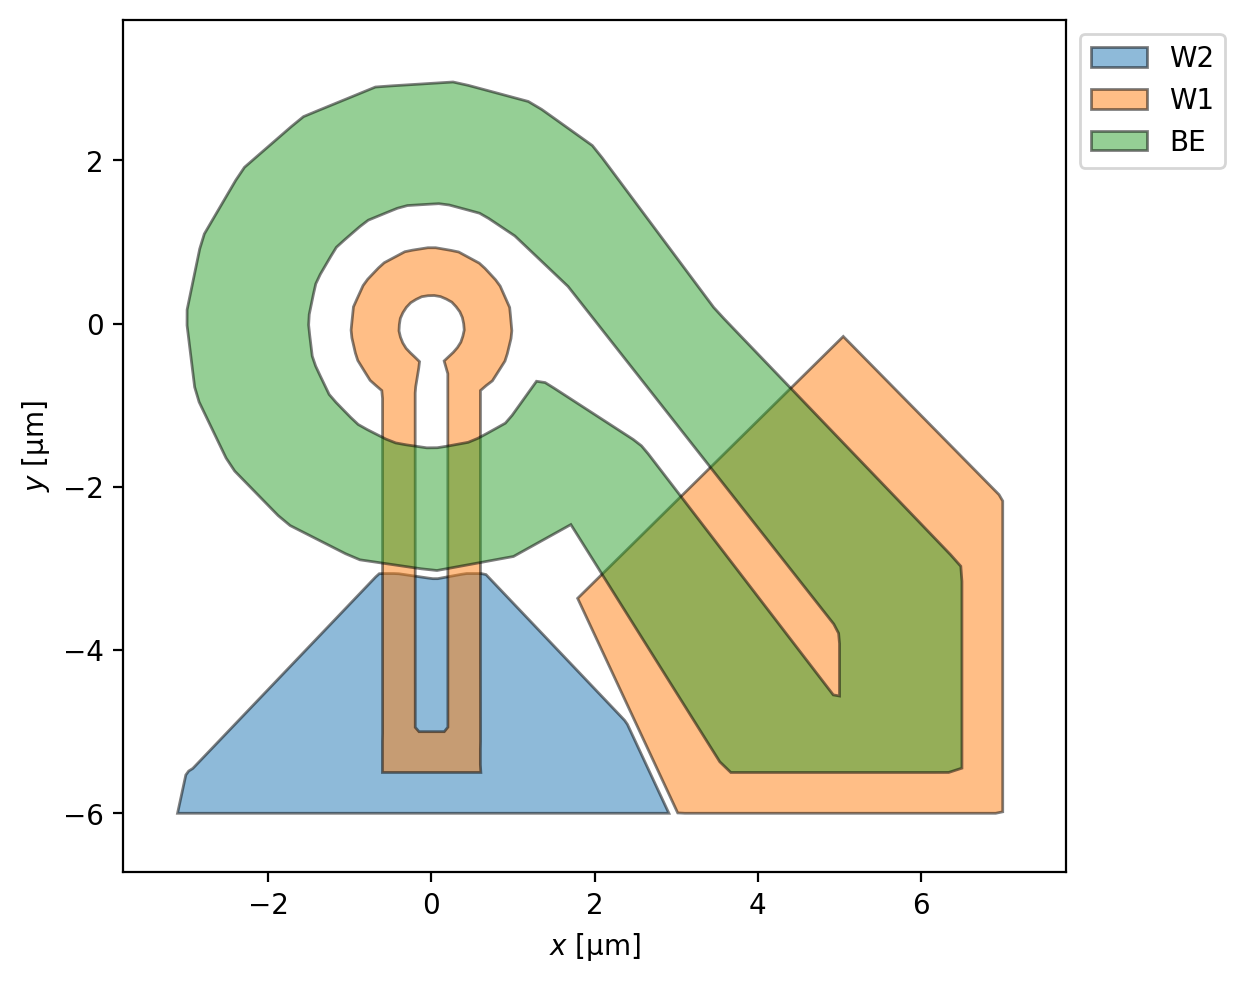

In [3]:
fig, ax = squid.draw(exclude="bounding_box", legend=True)

In [4]:
squid.make_mesh(min_points=5000, smooth=100)

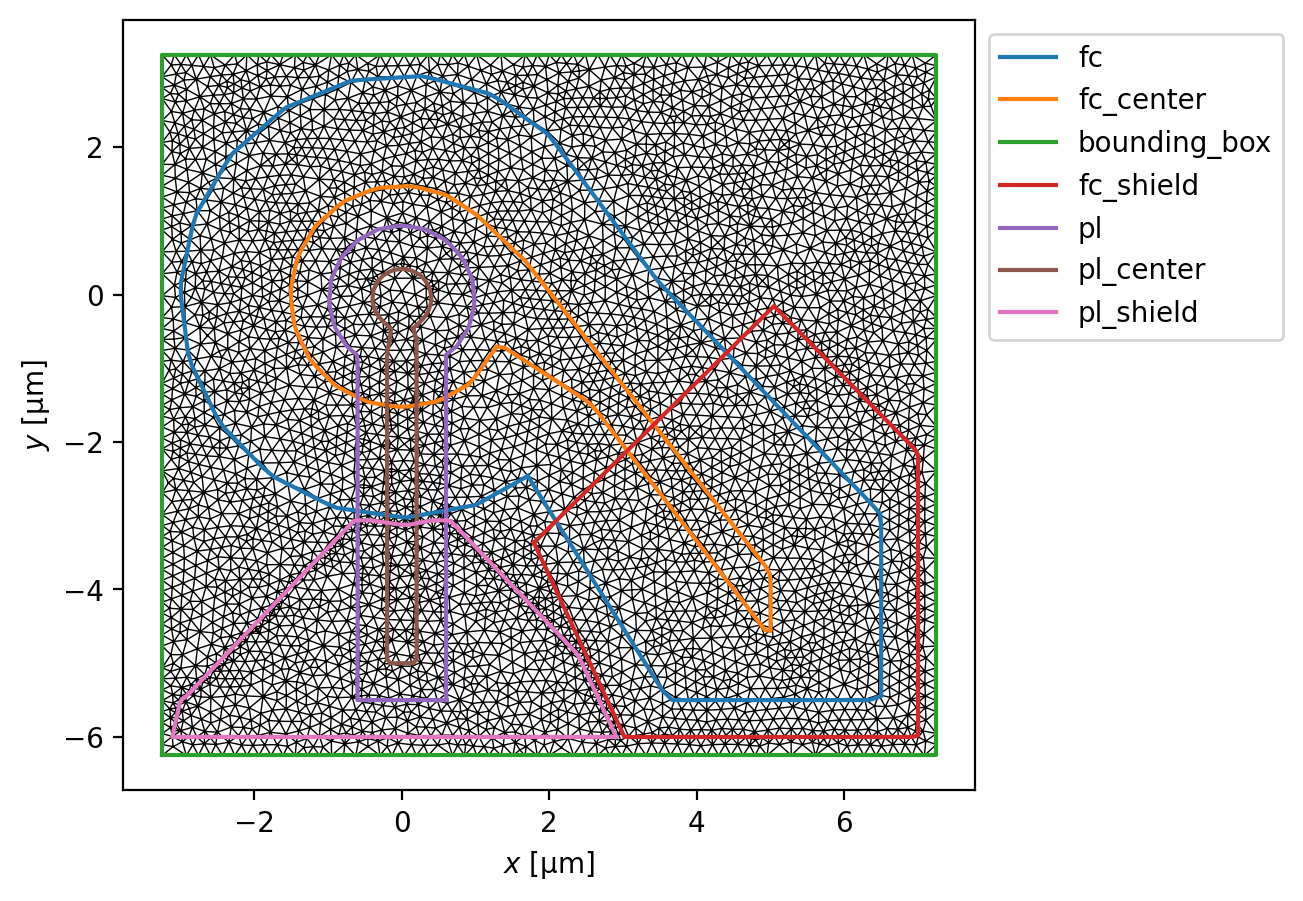

In [5]:
_ = squid.plot(mesh=True)

In [6]:
squid_solution = sc.solve(
    squid,
    circulating_currents=dict(fc_center=1),
    current_units="mA",
    field_units="mT",
    iterations=5,
)[-1]

In [7]:
z0 = 0.5  # SQUID height

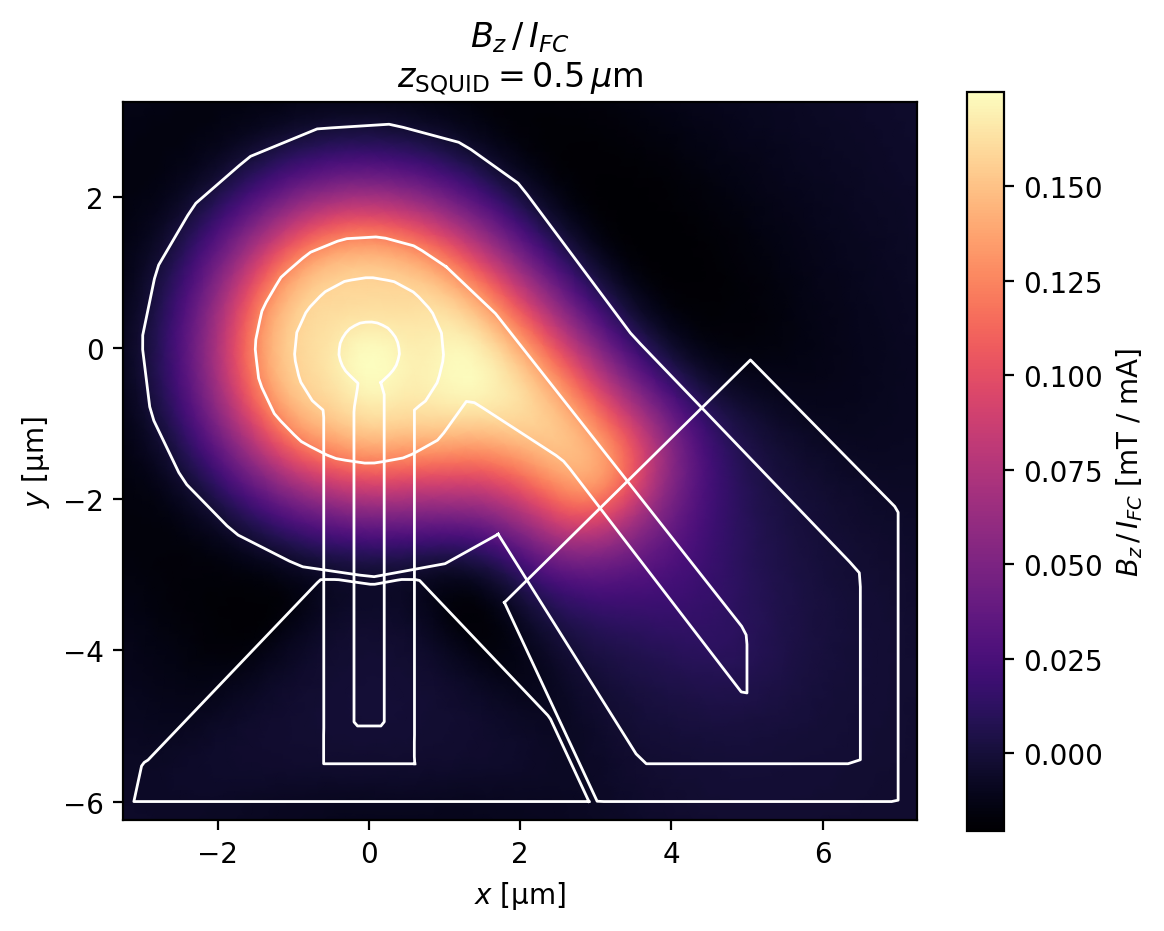

In [8]:
fig, ax = squid_solution.plot_field_at_positions(squid.points, zs=-z0, cmap="magma")
for a in ax:
    a.collections[0].colorbar.set_label("$B_z\\,/\\,I_{{FC}}$ [mT / mA]")
    a.set_title(f"$B_z\\,/\\,I_{{FC}}$\n$z_\\mathrm{{SQUID}}={{{z0}}}\\,\\mu\\mathrm{{m}}$")
    
    for polygon in squid.polygons.values():
        if polygon.name == "bounding_box":
            continue
        polygon.plot(ax=a, color="w", lw=1)

In [9]:
points, triangles = sc.Polygon(
    points=sc.geometry.box(13, center=(0.5, 0.5))
).make_mesh(min_points=4000)
Hz = squid_solution.field_at_position(points, zs=-z0, units="mT").m
A = squid_solution.vector_potential_at_position(points, zs=-z0, units="mT * um").m

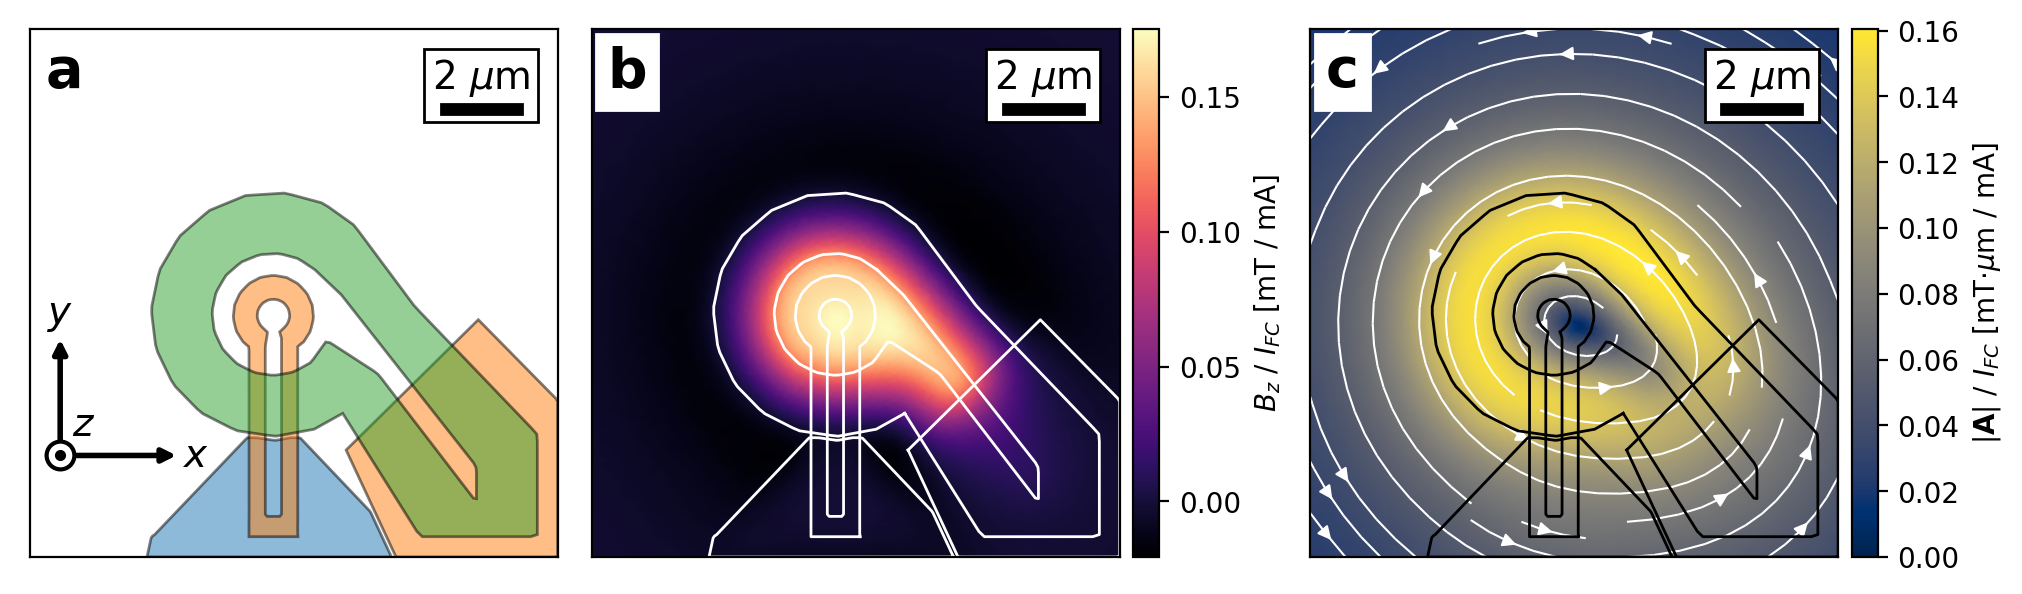

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2.85), constrained_layout=True)
    
ax, bx, cx = axes

xs = points[:, 0]
ys = points[:, 1]
ts = triangles

N = 101
x = np.linspace(xs.min(), xs.max(), N)
y = np.linspace(ys.min(), ys.max(), N)
X, Y = np.meshgrid(x, y)

Ax = griddata(points, A[:, 0], (X, Y))
Ay = griddata(points, A[:, 1], (X, Y))


squid.draw(ax=ax, exclude=["bounding_box", "pl_hole", "fc_hole"])

im = bx.tripcolor(xs, ys, Hz, triangles=ts, shading="gouraud", cmap="magma")
cbar_bx = fig.colorbar(im, ax=bx, pad=0.025)
cbar_bx.set_ticks([0, 0.05, 0.1, 0.15])
cbar_bx.set_label("$B_z$ / $I_{{FC}}$ [mT / mA]")
bx.tricontour(xs, ys, ts, Hz, levels=[0], colors="w",  alpha=0, zorder=100)

norm = np.linalg.norm(A, axis=1)
unit = A / norm[:, np.newaxis]
im = cx.tripcolor(xs, ys, ts, norm, shading="gouraud", cmap="cividis", vmin=0, vmax=None)
cx.streamplot(x, y, Ax, Ay, linewidth=0.75, color="w", density=0.55, broken_streamlines=True)
cbar_cx = fig.colorbar(im, ax=cx, pad=0.025)
cbar_cx.set_label("$|\\mathbf{A}|$ / $I_{{FC}}$ [mT$\\cdot\\mu$m / mA]")

for a, c, alpha in zip((bx, cx), ("w", "k"), (1, 1)):
    for polygon in squid.polygons.values():
        if polygon.name == "bounding_box":
            continue
        polygon.plot(ax=a, color=c, lw=1, ls="-", alpha=alpha)
    
ax.set_xlim(*bx.get_xlim())
ax.set_ylim(*bx.get_ylim())
cx.set_xlim(*bx.get_xlim())
cx.set_ylim(*bx.get_ylim())
        
scale = 2
for a, s, color in zip(axes, string.ascii_lowercase, ["none", "white", "white"]):
    a.set_aspect("equal")
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")

    scalebar = AnchoredSizeBar(
        a.transData,
        scale,
        f"{scale} $\\mu$m",
        "upper right",
        pad=0.2,
        borderpad=0.5,
        size_vertical=0.25,
        label_top=True,
        fontproperties=fm.FontProperties(size=14),
    )
    a.add_artist(scalebar)
    
    a.text(
        0.03, 0.97, s,
        ha="left", va="top",
        fontweight="bold", size=20, transform=a.transAxes,
        backgroundcolor=color,
    )
    
def add_arrow(ax, start, end):
    ax.annotate(
        text="",
        xy=end,
        xytext=start,
        arrowprops=dict(arrowstyle="-|>", lw=2, color="k"),
    )
    
axes_length = 3
r0 = np.array([-5.25, -3.5])
add_arrow(ax, r0, r0 + [0, axes_length])
add_arrow(ax, r0, r0 + [axes_length, 0])
ax.scatter(*r0, color="k", marker="o", s=100, facecolor="white", lw=1.5, zorder=100)
ax.scatter(*r0, color="k", marker=".", s=25, facecolor="k", lw=1.5, zorder=101)
ax.text(*(r0 + [axes_length, 0]), "$x$", ha="left", va="center", size=14)
ax.text(*(r0 + [0, axes_length]), "$y$", ha="center", va="bottom", size=14)
ax.text(*(r0 + [axes_length / 10, axes_length / 10]), "$z$", ha="left", va="bottom", size=14)

if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "squid-outline.pdf"), bbox_inches="tight")

In [11]:
Hz.max()

0.17503955219792514